<a href="https://colab.research.google.com/github/rvdinter/ddscm/blob/master/Adv_assig_DDSCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Assignment Data Driven Supply Chain Management
Before we do anything else, we need to install and import libraries that we are using in this notebook


In [0]:
# First install geopandas
!pip install geopandas

In [0]:
# Then import libraries
import geopandas


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance as geo_distance

from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, atan2, sqrt, radians
from shapely.geometry import LineString
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Polygon, Polygon, MultiPoint, Point

## 1. Data cleaning functions


### a. Open the .csv files

First, we want to import the log file. This file is located in my Google Drive. Therefore, we connect to the Drive and move to the correct location.

In [0]:
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Colab/DDSCM/Wk 1

I am using the Pandas library for easy dataframe manipulations. Furthermore, Pandas is a great library for data analytics.

In [0]:
raw_drone_data = pd.read_csv('log15_11.12.08.csv')
raw_drone_data.head()

,Id,Time(seconds),Time(text),Latitude,Longitude,FlightMode,Altitude(feet),Altitude(meters),HSpeed(mph),HSpeed(m/s),GpsSpeed(mph),GpsSpeed(m/s),HomeDistance(feet),HomeDistance(meters),HomeLatitude,HomeLongitude,GpsCount,BatteryPower(%),BatteryVoltage,BatteryVoltageDeviation,BatteryCell1Voltage,BatteryCell2Voltage,BatteryCell3Voltage,BatteryCell4Voltage,VelocityX,VelocityY,VelocityZ,Pitch,Roll,Yaw,Yaw(360),RcAileron,RcElevator,RcGyro,RcRudder,RcThrottle,NonGpsError,GoHomeStatus,AppTip,AppWarning,AppMessage
0,1,0.3,0m 0.3s,51.99247851,5.64997137,P-GPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,17.108,0.005,4.274,4.278,4.277,4.279,0.0,0.0,0.0,-1.4,-3.3,-24.3,335.7,364,364,1024,1684,364,NaN,NaN,NaN,NaN,NaN
1,2,0.4,0m 0.4s,51.9924785,5.64997137,P-GPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,17.108,0.005,4.274,4.278,4.277,4.279,0.0,0.0,0.0,-1.4,-3.3,-24.3,335.7,364,364,1024,1684,364,NaN,NaN,NaN,NaN,NaN
2,3,0.5,0m 0.5s,51.9924785,5.64997137,P-GPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,17.108,0.005,4.274,4.278,4.277,4.279,0.0,0.0,0.0,-1.4,-3.3,-24.3,335.7,364,364,1024,1684,364,NaN,NaN,NaN,NaN,NaN
3,4,0.6,0m 0.6s,51.9924785,5.64997138,P-GPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,0,17.108,0.005,4.274,4.278,4.277,4.279,0.0,0.0,0.0,-1.4,-3.3,-24.3,335.7,364,364,1024,1684,364,NaN,NaN,NaN,NaN,NaN
4,5,0.7,0m 0.7s,51.9924785,5.64997138,P-GPS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,95,17.108,0.005,4.274,4.278,4.277,4.279,0.0,0.0,0.0,-1.4,-3.3,-24.3,335.7,364,364,1024,1684,364,NaN,NaN,NaN,NaN,NaN


### b. Read and edit a specific data field and value


We keep only the columns that we need

In [0]:
required_columns = ['Time(seconds)','Latitude','Longitude','Altitude(meters)','HSpeed(m/s)']
drone_data = raw_drone_data[required_columns]
drone_data.head()

,Time(seconds),Latitude,Longitude,Altitude(meters),HSpeed(m/s)
0,0.3,51.99247851,5.64997137,0.0,0.0
1,0.4,51.9924785,5.64997137,0.0,0.0
2,0.5,51.9924785,5.64997137,0.0,0.0
3,0.6,51.9924785,5.64997138,0.0,0.0
4,0.7,51.9924785,5.64997138,0.0,0.0


### c. For each data field detect the amount of erroneous characters (EC) and/or missing characters (MC)


The method below is used to show the amount of missing or erroneous characters in the dataset. For my case, it showed
> Column | EC/MC
> --- | ---
> Time(seconds) | 0
> Latitude | 8
> Longitude | 10
> Altitude(meters) | 9
> HSpeed(m/s) | 0

In [0]:
drone_data.isna().sum()

Time(seconds)        0
Latitude             8
Longitude           10
Altitude(meters)     9
HSpeed(m/s)          0
dtype: int64

### d. Propose and code in Python a procedure to automatically substitute the EC and MC for valid values


A fix would be to use pd.to_numeric to convert the object arrays to numeric arrays.

With `errors='coerce'`, any value that could not be converted to a number (e.g. MC/EC) is converted to `NaN`. Afterwards we fill `NaN` data by padding the dataframe. It is not needed to interpolate due to the small variations of values

In [0]:
drone_data_nones = drone_data.copy()
for col in drone_data_nones:
    drone_data_nones[col] = pd.to_numeric(drone_data_nones[col], errors='coerce')

filled_drone_data = drone_data_nones.fillna(method ='pad') 
filled_drone_data.isna().sum()

Time(seconds)       0
Latitude            0
Longitude           0
Altitude(meters)    0
HSpeed(m/s)         0
dtype: int64

## 2. Plotting Functions


### a. Plot a histogram with the EC and MC occurrences.


First we show a histogram of occurences of missing and/or erroneous characters of the raw dataset, and then the padded dataset. The padded dataset only contains fields with 0 EC/MC values

Text(0, 0.5, '# of Columns')

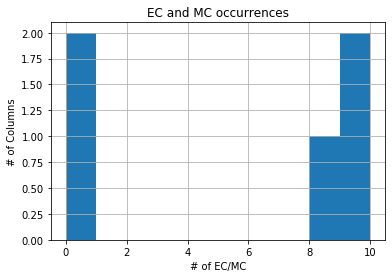

In [0]:
drone_data.isna().sum().hist()
plt.title('EC and MC occurrences')
plt.xlabel('# of EC/MC')
plt.ylabel('# of Columns')

Text(0, 0.5, '# of Columns')

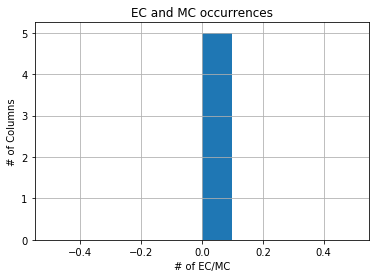

In [0]:
filled_drone_data.isna().sum().hist()
plt.title('EC and MC occurrences')
plt.xlabel('# of EC/MC')
plt.ylabel('# of Columns')

### b. Plot the Drone position in the XYZ plane


We show a 3d plot of the latitude, longitude and altitude of the drone. I tried to make it interactive using plotly; however, Google Colab did not allow to render it.

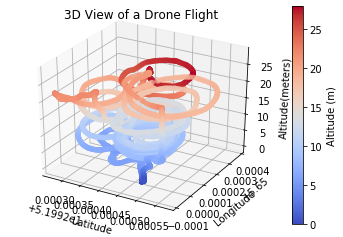

In [0]:
fig = plt.figure()
xyz = fig.gca(projection='3d')
plot = xyz.scatter(filled_drone_data['Latitude'], filled_drone_data['Longitude'], filled_drone_data['Altitude(meters)'], c=filled_drone_data['Altitude(meters)'], cmap='coolwarm')

xyz.set_title('3D View of a Drone Flight')
xyz.set_xlabel('Latitude')
xyz.set_ylabel('Longitude')
xyz.set_zlabel('Altitude(meters)')
fig.colorbar(plot, label='Altitude (m)')
plt.show()

**Extra:** I've added a top view plot, to enable visibility where the drone actually started flying.

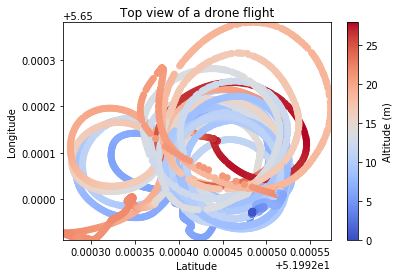

In [0]:
plt.scatter(filled_drone_data['Latitude'], filled_drone_data['Longitude'], c=filled_drone_data['Altitude(meters)'], cmap='coolwarm')

plt.xlim(filled_drone_data['Latitude'].min(), filled_drone_data['Latitude'].max())
plt.ylim(filled_drone_data['Longitude'].min(), filled_drone_data['Longitude'].max())
plt.title('Top view of a drone flight')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Altitude (m)')
plt.show()

## 3. Measuring Functions


### a. What was the average drone flying height during the flight?


Average height can be calculated by using the mean() function

In [0]:
print("Average height is: ", filled_drone_data['Altitude(meters)'].mean(), "m")

Average height is:  12.44203468882084 m


### b. What was the distance travelled by the drone during the flight?


####First attempt:
Total flying distance in kilometers, this was first calculated using the longitude, latitude and altitude

In [0]:
# Lambda functions to calculate distance
r = 6371
difference = lambda x1, x2: x2 - x1
a = lambda lat1, lon1, lat2, lon2: (sin(difference(lat1, lat2)/2))**2 + cos(lat1) * cos(lat2) * (sin(difference(lon1, lon2)/2))**2
c = lambda lat1, lon1, lat2, lon2: 2 * atan2( sqrt(a(lat1, lon1, lat2, lon2)), sqrt(1-a(lat1, lon1, lat2, lon2)) )
dist = lambda lat1, lon1, lat2, lon2, alt1, alt2: sqrt((r*c(lat1, lon1, lat2, lon2))**2 + difference(alt1, alt2)**2)

# Add two shifted columns for easy calculation
filled_drone_data['lon'] = filled_drone_data['Longitude'].shift(-1)
filled_drone_data['lat'] = filled_drone_data['Latitude'].shift(-1)
filled_drone_data['alt'] = filled_drone_data['Altitude(meters)'].shift(-1)

# Apply Lambda function over the drone_data and sum all subdistances
filled_drone_data['distance'] = filled_drone_data.apply(lambda row: dist(radians(row['Latitude']), radians(row['Longitude']), radians(row['lat']), radians(row['lon']), row['Altitude(meters)'], row['alt']), axis=1)
distan = filled_drone_data['distance'].diff().sum()
print("Total flying distance is: ", distan, "km")

Total flying distance is:  0.09999889001641186 km


####Second attempt: 
Here we base total flying distance ($km$) on the HSpeed ($m/s$), which is more accurate using:
>$Total Flying Distance = \sum(v*t)*1000^{-1}$

In [0]:
distan = filled_drone_data.apply(lambda row: row['HSpeed(m/s)']*0.1, axis=1).sum()/1000
print("Total flying distance is: ", distan, "km")

Total flying distance is:  1.13441 km


### c. What is the total field area


Total field area has been calculated by taking the distance between the upper and lower coordinates of the field. Total field area is represented in $m^2$. Distance has been calculated using the [Vincenty](https://geopy.readthedocs.io/en/stable/#module-geopy.distance) method.

In [0]:
len_lon = geo_distance.vincenty((filled_drone_data.Latitude.min(), filled_drone_data.Longitude.min()), (filled_drone_data.Latitude.min(), filled_drone_data.Longitude.max())).meters
len_lat = geo_distance.vincenty((filled_drone_data.Latitude.min(), filled_drone_data.Longitude.min()), (filled_drone_data.Latitude.max(), filled_drone_data.Longitude.min())).meters

total_field_area = len_lon*len_lat
print("Lengths of the field are: ", len_lon, "m and ", len_lat, "m")
print("Total Field Area is: ", total_field_area, "m^2")

Lengths of the field are:  32.1956186925981 m and  34.01549854757447 m
Total Field Area is:  1095.150020876332 m^2


### d. What was the effective ground area covered by the drone during the flight?


Effective ground area covered by the drone shown in a plot

Effective Ground Area Covered by the drone: 300.33 square meters


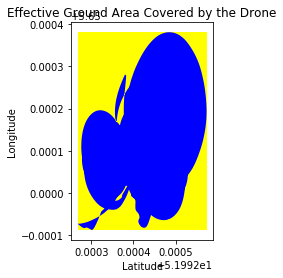

In [0]:
# Create polygons from the field and the flight coordinates
field = Polygon([(filled_drone_data.Latitude.min(), filled_drone_data.Longitude.min()), 
             (filled_drone_data.Latitude.min(), filled_drone_data.Longitude.max()), 
             (filled_drone_data.Latitude.max(), filled_drone_data.Longitude.max()), 
             (filled_drone_data.Latitude.max(), filled_drone_data.Longitude.min())])
flight = Polygon(list(zip(filled_drone_data.Latitude, filled_drone_data.Longitude)))

g_field = GeoSeries(field)
g_flight = GeoSeries(flight)

df1 = GeoDataFrame({'geometry': g_field, 'df1':[1]})
df2 = GeoDataFrame({'geometry': g_flight, 'df2':[1]})

# Plot the polygons over eachother
ax = df1.plot(color='yellow')
df2.plot(ax=ax, color='blue')
plt.title('Effective Ground Area Covered by the Drone')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

cov_ratio = g_field.area/g_flight.area
effective_ground_area_cov = total_field_area * cov_ratio

print("Effective Ground Area Covered by the drone: %0.2f square meters"%effective_ground_area_cov[0])

## 4. Mapping function


### a. Develop a script that generates a density map with respect to the position of each tree in the orchard


####First attempt:
I created a GeoPandas representation of the field, however it is very difficult to calculate count of intersections with the trees, therefore I needed to find another method

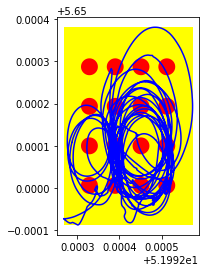

In [0]:
trees = 16

tree_dist_lon = (filled_drone_data.Longitude.max() - filled_drone_data.Longitude.min()) / (trees/4+1)
tree_dist_lat = (filled_drone_data.Latitude.max() - filled_drone_data.Latitude.min()) / (trees/4+1)

flight = LineString(list(zip(filled_drone_data.Latitude, filled_drone_data.Longitude)))
g_flight = GeoSeries(flight)
df3 = GeoDataFrame({'geometry': g_flight, 'df3':[1]})

tree_coords = []
min_lat = filled_drone_data.Latitude.min()
for i in range(0,int(trees/4)):
  min_long = filled_drone_data.Longitude.min()
  min_lat = min_lat+tree_dist_lat
  for i in range(0,int(trees/4)):
    min_long = min_long + tree_dist_lon
    tree_coords.append(Point(min_lat, min_long))

pts = GeoSeries(tree_coords)
circles = pts.buffer(0.00002)
mp = circles.unary_union
holes = g_field.intersection(mp)
df4 = GeoDataFrame({'geometry': holes})
ax = df1.plot(color='yellow')
gx = df3.plot(ax=ax, color='blue')
df4.plot(ax=gx, color='red')

####Second attempt:
First we put coordinates of trees inside a pd Dataframe, then count occurences of coming close to trees

Text(0, 0.5, '# of hits')

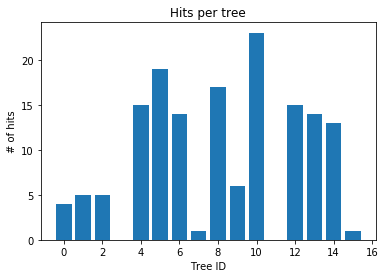

In [0]:
# Put coordinates of trees in a list
trees = 16
tree_coords = []

min_lat = filled_drone_data.Latitude.min()
for i in range(0,int(trees/4)):
  min_long = filled_drone_data.Longitude.min()
  min_lat = min_lat+tree_dist_lat
  for i in range(0,int(trees/4)):
    min_long = min_long + tree_dist_lon
    tree_coords.append((min_lat, min_long))

# Convert that list into a Pandas dataframe
tree_coords = pd.DataFrame(tree_coords, columns=['lat', 'lon'])


subset = filled_drone_data[['Latitude', 'Longitude']]
tuples = [tuple(x) for x in subset.to_numpy()]
  
def count_hits(x, y):
  occurences =0
  for x1, y1 in tuples:
    if x - 5*10**-5 <= x1 <= x + 5*10**-5 and y - 1*10**-6 <= y1 <= y + 1*10**-6:
      occurences += 1
  return occurences

tree_coords['count'] = tree_coords.apply(lambda row: count_hits(row['lat'], row['lon']), axis=1)

plt.bar(range(16), tree_coords['count'])
plt.title('Hits per tree')
plt.xlabel('Tree ID')
plt.ylabel('# of hits')

####Now we can plot the heatmap!

Text(0, 0.5, 'Longitude')

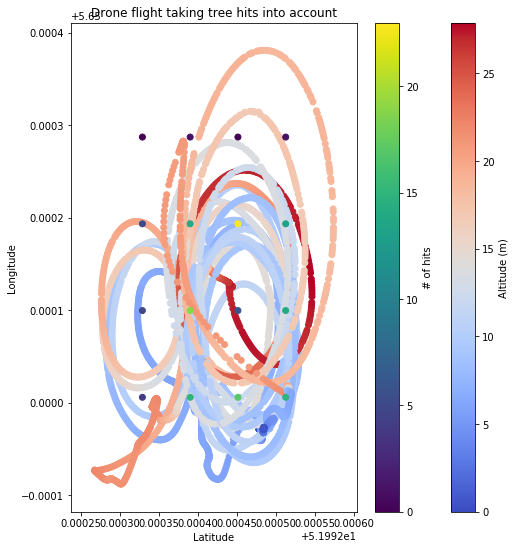

In [0]:
plt.figure(figsize=(8, 9))
plt.scatter(filled_drone_data['Latitude'], filled_drone_data['Longitude'], c=filled_drone_data['Altitude(meters)'], cmap='coolwarm')
plt.colorbar(label='Altitude (m)')
plt.scatter(x=tree_coords.lat, y=tree_coords.lon, c=tree_coords['count'], cmap='viridis')
plt.colorbar(label='# of hits')

plt.xlim(filled_drone_data['Latitude'].min()- 0.00003, filled_drone_data['Latitude'].max()+ 0.00003)
plt.ylim(filled_drone_data['Longitude'].min()- 0.00003, filled_drone_data['Longitude'].max()+ 0.00003)

plt.title('Drone flight taking tree hits into account')
plt.xlabel('Latitude')
plt.ylabel('Longitude')